# GLM-PCA analysis of single-cell methylome data



Starting from the publicly available single-cell methylation data from [snmCATseq](https://www.sciencedirect.com/science/article/pii/S2666979X22000271?via%3Dihub) , we re-processed a subset of the data to extract methlated/unmethylated reads in small genomics bins (10kb), yielding non-Gaussian data (see tutorial on preprocessing [here](https://sincei.readthedocs.io/en/latest/content/tutorials/snmCATseq_preprocessing.html)). 

This data was stored as pickle files `snmC2Tseq_eckerlab/10k_bin/processed_data_*_2024_06_13.pkl`, which we will import here.

Another file named `mmc5.xlsx` contains metadata for celltype identification.

The data is losely following a Beta distribution, and we thus employ GLM-PCA with Beta distribution to find a lower-dimension representation.


In [1]:
import tqdm, umap
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sincei.GLMPCA import GLMPCA

data_type = 'HCGN'

## Read data


Starting from the files provided in our figshare repository, the data needs to be first processed as demonstrated in "snmCATseq_prepcessing.ipynb". We here load the output.

In order to confirm whether glmPCA results help in identifying clusters of cells, we shall also load the celltype metadata provided in the Supplementary table 5 of the original manuscript.


In [3]:
# methylation (number of methylated covered)
df_cov = pd.read_csv(
    'snmC2Tseq_eckerlab/processed_data_%s_2024_06_13.csv.gz'%(data_type),
    index_col=[0,1],
    compression='gzip'
)

X_data = df_cov.values
X_data = X_data[:, np.where(np.std(X_data,axis=0)>0.08)[0]] # Previously 0.08

Now we can open the metadata from the original manuscript.
*NOTE*: loading it requires `openpyxl`. You may install it by running `conda install openpyxl` in your environment.

In [4]:
# Metadata from the paper
metadata_df = pd.read_excel('snmC2Tseq_eckerlab/mmc5.xlsx', sheet_name=1, header=1)

# Structure metadata
metadata_df['sample_idx'] = metadata_df['Sample'].apply(lambda x: '_'.join(x.split('_')[1:11]))
metadata_df = metadata_df.set_index('sample_idx')

X_data_index = ['_'.join(e.split('/')[-1].split('.')[0].split('_')[3:13]) for e in  df_cov.loc[data_type].index]
cell_labels = metadata_df.loc[X_data_index]

## Sincei: GLM-PCA

To aid in this analysis, we provide two Beta families within the glmPCA framework: **Beta** and **SigmoidBeta**. 

SigmoidBeta employs a logit-transformed saturated parameters, which removes all optimisation constraints and is therefore much more stable.


Several hyper-parameters are hard-coded, but do not vastly influence the analysis. The only hyper-parameter which can change results fondamentally is the learning rate. 2.5 is a good choice for sigmoid_beta, but this needs to be changed for other distributions.

In [ ]:
eps = 1e-5
n_pc = 20
family = 'sigmoid_beta'

clf = GLMPCA(
    n_pc=n_pc, 
    family=family, 
    n_jobs=5, 
    max_iter=500,
    learning_rate=10., 
)

Beta distribution not initialized yet


In [6]:
# Imputes zeros with mean
X_glm_data = X_data.copy()
for idx in tqdm.tqdm(range(X_data.shape[1])):
    non_zero_mean = X_glm_data[X_glm_data[:,idx] != 0,idx].mean()
    X_glm_data[X_glm_data[:,idx] == 0,idx] = non_zero_mean

clf.fit(torch.Tensor(X_glm_data))

 21%|██████████████████████████████████████████████▌                                                                                                                                                                               | 21/100 [00:06<00:23,  3.35it/s]

CONVERGENCE AFTER 21 ITERATIONS


LEARNING RATE: 10.0


  7%|████████████████▍                                                                                                                                                                                                             | 37/500 [00:42<08:47,  1.14s/it]

	RESTART BECAUSE INF/NAN FOUND
LEARNING RATE: 5.0


  7%|████████████████▎                                                                                                                                                                                                           | 37/500 [10:45<2:14:40, 17.45s/it]


True

Text(0, 0.5, 'Training loss')

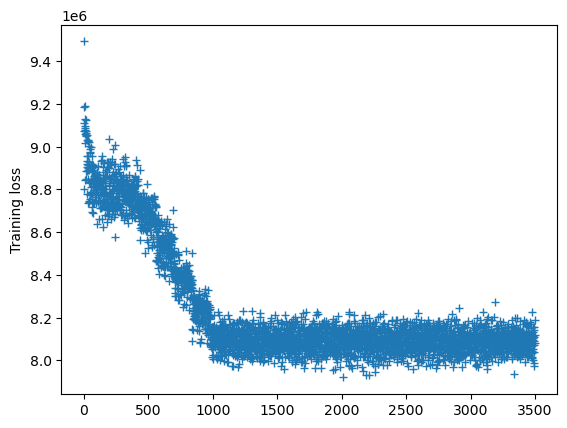

In [7]:
# Learning curves: needs to reach a plateau.
plt.plot(np.array(clf.loadings_learning_scores_).T, '+')
plt.ylabel('Training loss')

In [8]:
X_project = clf.transform(torch.Tensor(X_glm_data))

 21%|██████████████████████████████████████████████▌                                                                                                                                                                               | 21/100 [00:09<00:35,  2.24it/s]

CONVERGENCE AFTER 21 ITERATIONS


### UMAP on GLM-PCA

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.3, n_epochs=1000, verbose=True)
Wed Nov 26 23:04:08 2025 Construct fuzzy simplicial set
Wed Nov 26 23:04:10 2025 Finding Nearest Neighbors
Wed Nov 26 23:04:14 2025 Finished Nearest Neighbor Search
Wed Nov 26 23:04:15 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Wed Nov 26 23:04:18 2025 Finished embedding


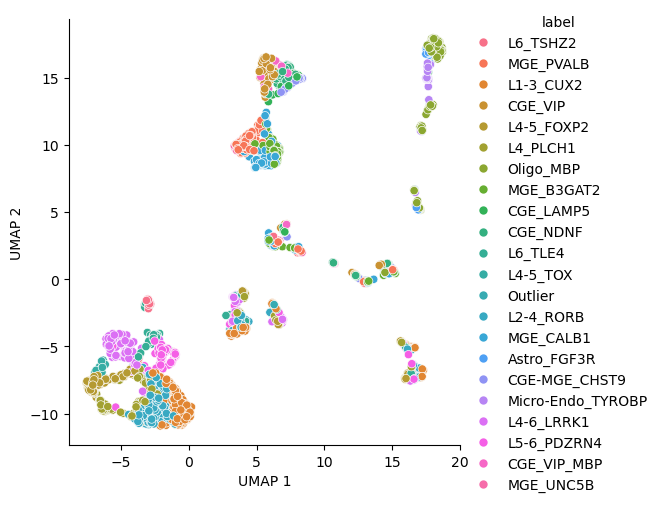

In [9]:
_umap_params = {'n_neighbors':15, 'min_dist': 0.3, 'n_epochs': 1000}

metric = 'cosine'

_umap_clf = umap.UMAP(metric=metric, verbose=True, **_umap_params)
umap_embeddings = pd.DataFrame(
    _umap_clf.fit_transform(X_project.detach().numpy()), 
    columns=['UMAP 1', 'UMAP 2']
).reset_index()
umap_embeddings['label'] = cell_labels['snmC2T-seq Baseline Cluster'].values

g = sns.relplot(data=umap_embeddings, x='UMAP 1', y='UMAP 2',hue='label')
figure_name = 'UMAP_glm_pca_%s_metric_%s_%s'%(
    n_pc, 
    metric,
    family
)

## Compare to regular SVD-based PCA.

In [10]:
pca_clf = PCA(n_pc).fit(X_data)
X_pca = pca_clf.transform(X_data)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.3, n_epochs=1000, verbose=True)
Wed Nov 26 23:04:19 2025 Construct fuzzy simplicial set
Wed Nov 26 23:04:21 2025 Finding Nearest Neighbors
Wed Nov 26 23:04:21 2025 Finished Nearest Neighbor Search
Wed Nov 26 23:04:21 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Wed Nov 26 23:04:22 2025 Finished embedding


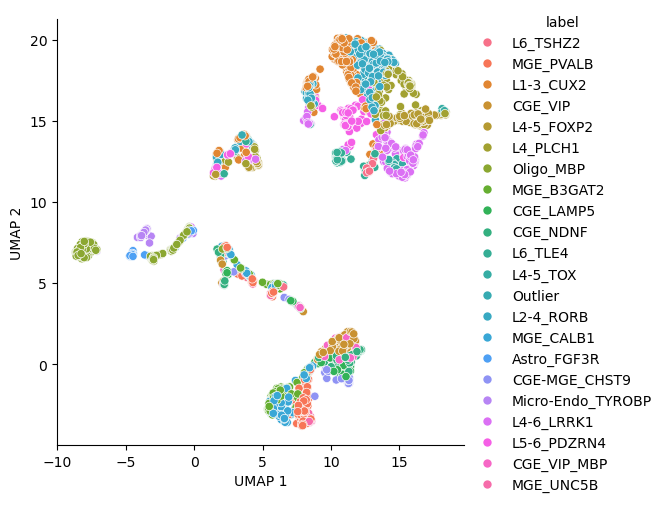

In [11]:
_umap_params = {'n_neighbors':15, 'min_dist': 0.3, 'n_epochs': 1000}

metric = 'cosine'
_umap_clf = umap.UMAP(metric=metric, verbose=True, **_umap_params)
umap_embeddings = pd.DataFrame(
    _umap_clf.fit_transform(X_pca), 
    columns=['UMAP 1', 'UMAP 2']
).reset_index()
umap_embeddings['label'] = cell_labels['snmC2T-seq Baseline Cluster'].values

g = sns.relplot(data=umap_embeddings, x='UMAP 1', y='UMAP 2',hue='label')

## Compare directions found by GLM-PCA and regular PCA
### Cosine similarity

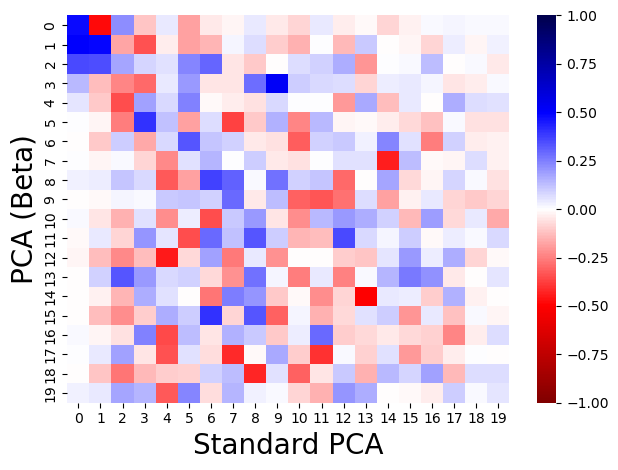

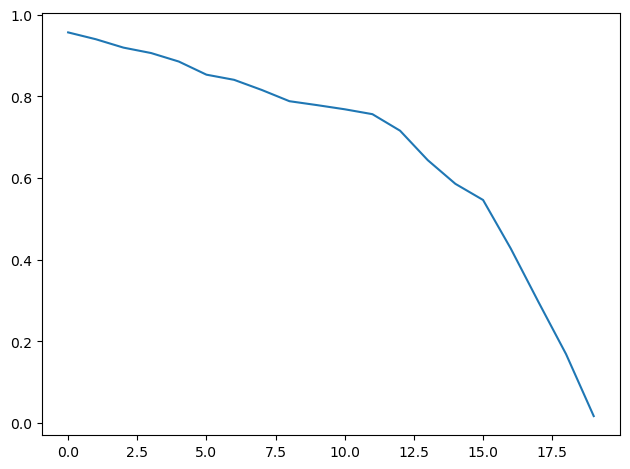

In [12]:
M = clf.saturated_loadings_.detach().numpy().T.dot(pca_clf.components_.T)
sns.heatmap(M, cmap='seismic_r', center=0, vmax=1, vmin=-1)
plt.ylabel('PCA (Beta)', fontsize=20)
plt.xlabel('Standard PCA', fontsize=20)
plt.tight_layout()
plt.show()

plt.plot(np.linalg.svd(M)[1])
plt.tight_layout()
plt.show()